# Aim
To train a baseline non-transformer model for single-label classification of the Huffington Post news dataset.

Ultimately the baseline model can be compared with a transformer classifier to determine if transformer models can perform better than non-transformer models in an NLP single-label classification of an imbalanced dataset.

## Dataset
Huffington News headline texts downloaded from https://www.kaggle.com%2Fdatasets%2Frmisra%2Fnews-category-dataset%2Fdata.

Exploratory analysis of this is in the huffpost-news-EDA notebook (link).

## Modelling approaches

### Non-transformer models:
- Naive Bayes
- Random Forest
- Logistic Regression
- Support Vector Machine

To use k-fold cross-validation to determine which is the best performing non-transformer model
### Huggingface's Transformer (DistilBERT)
- Using Huggingface's Pytorch Trainer API to fine-tune DistilBERT

### Data treatments
(1) None: use imbalanced dataset as is for both types of models to see if transformers have any advantages over non-transformer models for imbalanced data
(2) Oversampling of minority classes
(3) Undersampling of majority classes

### Metrics
Compare Accuracy and F1 scores


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# import transformers
# print(transformers.__version__)
# from transformers import Trainer


In [1]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

# (A) Dataset
The dataset is the original downloaded dataset

In [30]:
data = pd.read_csv(r"/content/data_EDA.csv", usecols=['headline', 'category']) # For Google colab notebook
data.rename(columns={'headline':'text', 'category':'label'}, inplace=True)

In [31]:
# Load dataset (get text and target columns only)
len(data)

15619

In [32]:
print(f"Number of categories: {data['label'].nunique()}\n")

ct = data.label.value_counts().rename_axis('label').reset_index(name='count')
ct['percent'] = ((ct['count']/ct['count'].sum())*100).round(2)
ct

Number of categories: 32



,label,count,percent
0,POLITICS,5383,34.46
1,ENTERTAINMENT,2718,17.40
2,WORLD NEWS,1562,10.00
3,U.S. NEWS,1377,8.82
4,COMEDY,595,3.81
5,SPORTS,523,3.35
6,BLACK VOICES,405,2.59
7,QUEER VOICES,404,2.59
8,MEDIA,369,2.36
9,CRIME,309,1.98


There are 4 major categories that account for more than 72% of the dataset:
- Politics (34.6%)
- Entertainment (17.1%)
- World News (10.7%)
- U.S. News (10.7%)

The remaining 28% of the data consists of 28 minor categories.
Some of the minor categories have less than 10 entries i.e. too few learning examples for training of a model. A few of the small categories may overlap (e.g. Tech and Business), and might be better consolidated into larger categories for training.

Hence at this point we focus only on categories with 500 or more training examples.

In [33]:
# Function to keep the categories with a minimum number (n) of entries
cat_counts = data['label'].value_counts()

def cat_dropper(df, n):
  '''
  Takes in a dataframe, and a minimum number (n) of entries required for categories
  Drops rows belonging to categories that have less than n entries in the dataframe
  Returns dataframe with categories that have n or more entries

  '''
  df1 = df.loc[df['label'].isin(cat_counts[cat_counts >= n].index)]
  print(f"Number of rows dropped = {len(df)- len(df1)}")
  return df1

In [34]:
df1 = cat_dropper(data, 500)
df1.info() # 12158 rows

Number of rows dropped = 3461
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12158 entries, 0 to 15617
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12158 non-null  object
 1   label   12158 non-null  object
dtypes: object(2)
memory usage: 285.0+ KB


# (B) Processing dataset for training

In [54]:
# Write a dataframe processor function
class Processor:
  """
  A class to process a dataframe containing text and category label columns
  to produce label-to-id dictionaries for mapping category labels to numerical label id's.
  """
  def __init__(self, df):
    # List classes present
    self.classes = np.unique(df['label']).tolist()
    # Make dictionaries for category labels to id's
    self.id2label = {id:label for id,label in enumerate(self.classes)}
    self.label2id = {id:label for label,id in enumerate(self.classes)}

  # Map category labels to their id's
  def map_id(self, df):
    df.loc[:,'label_id'] = df['label'].map(lambda x: self.label2id[x.strip()])
    return df

In [57]:
p = Processor(df1)

In [58]:
df1 = p.map_id(df1)
df1.head(3)

<ipython-input-54-a6d7bec6278a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'label_id'] = df['label'].map(lambda x: self.label2id[x.strip()])


,text,label,label_id
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,4
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,4
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,0


In [59]:
p.classes

['COMEDY', 'ENTERTAINMENT', 'POLITICS', 'SPORTS', 'U.S. NEWS', 'WORLD NEWS']

In [60]:
X_train, X_test, y_train, y_test, X_val, y_val = p.ttsplit(df1)

In [62]:
# Make lists of text data and label_id's
text = df1['text'].tolist()
labels = df1['label_id'].tolist()

In [63]:
# Partition into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, stratify=y_train, random_state=RANDOM_STATE)

In [64]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7780, 2432, 7780, 2432)

# (C) Feature engineering with TF-IDF
- Here we extract features from the text data in the form of numerical representations or vectors, before feeding these as inputs to a machine learning algorithm
- The vectorisation method chosen is Term-Frequency-Inverse Document Frequency (TF-IDF)
- TF-IDF is the product of 2 statistics, term frequency and inverse document frequency, that reflects how important a certain term is to a document in a corpus



In [49]:
# Make numerical representations of text data: TF-IDF
tfidf_params = dict(sublinear_tf=True, # scales term frequency to log scale (replaces tf with 1+log(tf))
                    min_df=5, # when building vocabulary, removes words that occur less than min_df number of files in corpus
                    ngram_range=(1,2), # upper and lower boundary of range of n values for n-gram extraction
                    stop_words='english', # passes the list of stop words to be removed
                    smooth_idf=True, # smooth idf weights by adding 1 to document frequencies (as if there's an extra document that contains every term in the collection once); prevents zero division error
                    norm='l2', #optional: this normalizes term vectors, 'None' for no normalization
                    )

In [51]:
tfidf = TfidfVectorizer(**tfidf_params)
features = tfidf.fit_transform(text).toarray() # Learn vocabulary and return tfidf matrix
print(f'{features.shape[0]} data rows represented by {features.shape[1]} features.')

## TODO: What exactly are these features?

12158 data rows represented by 4981 features.


In [65]:
# Make classification pipeline: vectorise data, then pass as inputs to train a model

clf = Pipeline(steps=[
    ('features', TfidfVectorizer(**tfidf_params)),
    ('model', MultinomialNB())
    ])

# Fit the pipeline to data (training the model)
clf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words='english', sublinear_tf=True)),
                ('model', MultinomialNB())])

# (D) Baseline: Naive Bayes Classifier

In [70]:
# Classifier metrics

def classifier_metrics(y_pred, y_true, id2label, classes):
  """
  Takes lists of predictions of label id's and their true id's.
  Returns confusion matrix and classification report, with the id's mapped to their labels, (as defined by id2label and label2id dictionaries)
  """
  result = pd.DataFrame(columns=['y_pred_id', 'y_pred'])
  result.loc[:, 'y_pred_id'] = y_pred
  result.loc[:, 'y_pred'] = result['y_pred_id'].map(id2label)
  result.loc[:, 'y_true_id'] = y_true
  result.loc[:, 'y_true'] = result['y_true_id'].map(id2label)
  print(result)

  cm = confusion_matrix(result['y_true'], result['y_pred'], labels=classes)
  display = ConfusionMatrixDisplay(cm, display_labels=classes).plot()
  plt.xticks(rotation=70)
  plt.show()
  print(classification_report(
      y_true=result['y_true'], y_pred=result['y_pred'],
      labels=classes, zero_division=True))
  return result, cm

In [71]:
# Use trained model to predict on test data
y_pred = clf.predict(X_test)

      y_pred_id         y_pred  y_true_id         y_true
0             2       POLITICS          2       POLITICS
1             5     WORLD NEWS          5     WORLD NEWS
2             2       POLITICS          2       POLITICS
3             2       POLITICS          2       POLITICS
4             1  ENTERTAINMENT          1  ENTERTAINMENT
...         ...            ...        ...            ...
2427          2       POLITICS          2       POLITICS
2428          1  ENTERTAINMENT          1  ENTERTAINMENT
2429          2       POLITICS          2       POLITICS
2430          2       POLITICS          4      U.S. NEWS
2431          1  ENTERTAINMENT          4      U.S. NEWS

[2432 rows x 4 columns]


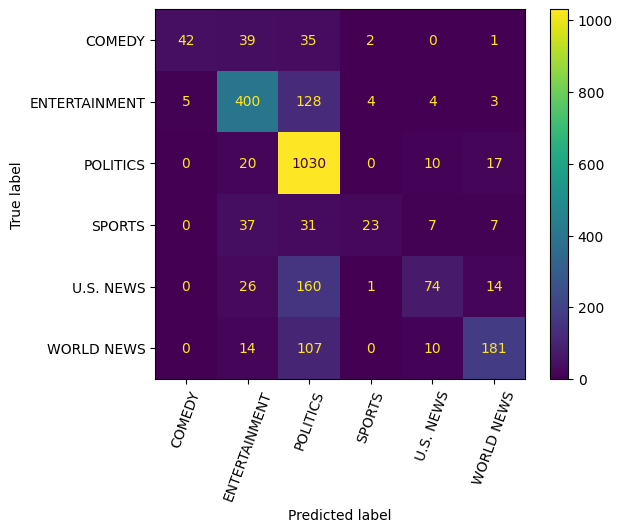

               precision    recall  f1-score   support

       COMEDY       0.89      0.35      0.51       119
ENTERTAINMENT       0.75      0.74      0.74       544
     POLITICS       0.69      0.96      0.80      1077
       SPORTS       0.77      0.22      0.34       105
    U.S. NEWS       0.70      0.27      0.39       275
   WORLD NEWS       0.81      0.58      0.68       312

     accuracy                           0.72      2432
    macro avg       0.77      0.52      0.58      2432
 weighted avg       0.73      0.72      0.69      2432



In [72]:
# Score results of prediction
result, cm = classifier_metrics(y_pred, y_test, p.id2label, p.classes)

After training the Naive Bayes classifier to classify headlines into 6 categories, 3 of the major categories (Politics, Entertainment and World News) are showing F1 scores of 0.68 or more. The 4th major category, U.S. News, had F1 score of 0.39. Predictions for minor categories are rather poor, with 0.3 to 0.5 F1 score, as expected, due to insufficient learning examples relative to the large categories.

Accuracy averages at 0.72, weighted average accuracy is at 0.69.

Recall scores for the smaller categories are generally poor e.g. 0.27 for U.S. News, 0.22 for Sports, as many articles from the minor classes get classified into the large classes, which results in poor recall for these minor classes.

The Politics category appears to draw in many wrongly classified items.

# (E) Comparing non-transformer models

We compare the performance of the baseline Naive Bayes classifier with other conventional non-transformer classifiers -- Logistic Regressor, Random Forest and Linear Support Vector Classifier.

This is done with 5-fold cross-validation to rule out effects of sampling during partitioning of train, test and validation datasets.

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

models = [MultinomialNB(),
          RandomForestClassifier(n_estimators=200, max_depth=10, random_state=RANDOM_STATE),
          LogisticRegression(max_iter=1000), # Increase iterations else convergence warning: "lbfgs failed to converge (status=1)"
          LinearSVC()]

CV = 5
cv_df = pd.DataFrame(index=range(CV*len(models)))

model_scores =[]
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring = 'accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    model_scores.append((model_name, fold_idx, accuracy))




In [74]:
model_scores

[('MultinomialNB', 0, 0.6681743421052632),
 ('MultinomialNB', 1, 0.694078947368421),
 ('MultinomialNB', 2, 0.7261513157894737),
 ('MultinomialNB', 3, 0.7375565610859729),
 ('MultinomialNB', 4, 0.7293294940353764),
 ('RandomForestClassifier', 0, 0.44942434210526316),
 ('RandomForestClassifier', 1, 0.44366776315789475),
 ('RandomForestClassifier', 2, 0.44901315789473684),
 ('RandomForestClassifier', 3, 0.4520773344302756),
 ('RandomForestClassifier', 4, 0.448786507610037),
 ('LogisticRegression', 0, 0.6949013157894737),
 ('LogisticRegression', 1, 0.7195723684210527),
 ('LogisticRegression', 2, 0.7598684210526315),
 ('LogisticRegression', 3, 0.765117235705471),
 ('LogisticRegression', 4, 0.762649115590292),
 ('LinearSVC', 0, 0.7080592105263158),
 ('LinearSVC', 1, 0.712171052631579),
 ('LinearSVC', 2, 0.765625),
 ('LinearSVC', 3, 0.762649115590292),
 ('LinearSVC', 4, 0.7700534759358288)]

In [ ]:
# TODO: tabulate model scores